In [1]:
#pip install missingno
#pip install feature_engine [posible conflicto con pycaret por versión de pandas..]
#pip install pyarrow (solo si se queja al instalar feature_engine)

In [ ]:
# Para mostrar plotly en notebook
#import plotly.io as pio
#pio.renderers.default='notebook'

# Opción para python 3.12 [gráficos de plotly en notebook]
import plotly.offline as pyo
import plotly.graph_objs as go

# Set notebook mode to work in offline
pyo.init_notebook_mode()


En este documento se exploran distintas posibilidades de estudio y depuración de un conjunto de datos con aplicación concreta al dataset de venta de vinos que se encuentra en la carpeta de Datos del material en formato cvs. Dado que la fase de "limpieza" de los datos es a crucial de cara a la obtención de modelos predictivos lo más libres posible de sesgos y problemas de estimación, es conveniente prestar atención e invertir el tiempo necesario en este proceso quizá explorando varias alternativas de las disponibles en base a la naturaleza de las distribuciones de las variables implicadas. 

La fase de depuración de los datos no suele atender a "recetas" pues con cada dataset, el cuerpo nos pedirá cosas distintas. Sin embargo, trataremos de generar un proceso lo más automático posible con los aspectos generales que seguro tenemos que atacar para poder tenerlo como guía de actuación. 

# Estudio descriptivo de datos sobre venta de vinos

En primer lugar, importamos las dos librerías por excelencia, numpy y pandas para trabajar con conjuntos de datos en python, y leemos los datos de entrada consignando la ruta adecuada a nuestra carpeta (evidentemente hay que cambiar la ruta en cada caso, dudo que tengáis carpetar Guille/Documents...jeje). Añadimos la opción de pandas para que muestre todas las filas y columnas de un dataset y no corte las salidas (esto puede ser peligroso con grandes conjuntos de datos!! Siempre tendremos cuidado de mostrar el head del archivo cuando haya peligro)


In [2]:
import pandas as pd
import numpy as np
#pd.set_option("display.max_rows", None, "display.max_columns", None)

# Lectura de datos
vinos = pd.read_csv(r'C:\Users\Guille\Documents\Material Minería de Datos 2024_25 Gr1\Datos\DatosVino.csv')
vinos.head()


,ID,Beneficio,Compra,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,Etiqueta,CalifProductor,Clasificacion,Region,PrecioBotella
0,2,515,1,0.16,-0.81,26.10,-0.425,1.02792,3.38,0.70,144.0,M,2,***,1.0,1.00
1,4,585,1,2.64,-0.88,14.80,0.037,0.99518,3.12,0.48,22.0,M,3,***,3.0,3.38
2,8,0,0,0.29,-0.40,21.50,0.060,0.99572,3.49,1.21,10.3,R,3,?,1.0,3.72
3,11,775,1,-1.22,0.34,1.40,0.040,1.03236,3.20,NaN,11.6,B,2,***,2.0,6.23
4,12,596,1,0.27,1.05,11.25,-0.007,0.99620,4.93,0.26,15.0,R,1,?,2.0,2.44


Este código está preparado para funcionar sobre los DatosVino. Se presenta en la siguiente tabla, la información sobre las variables contenidas en el archivo.

![](datosVino.png)

En la tabla de información de variables que acompaña a los datos, podemos comprobar los tipos que deberían tener las variables y sus posibles limitaciones sobre rangos, categorías "oficiales" etc. Esto nos sirve de guía para ir chequeando lo que deberíamos tener y lo que realmente encontramos (dos cosas que a menudo no van de la mano precisamente...)

## Que comprobar?

En el archivo total comprobaremos lo siguiente:

1- **Tipos de variables**. Todos los factores, lo son realmente en python?

2- **Valores mal codificados**. Hay missings no declarados tipo -1, 99999? Las categorías de las nominales son las que deben? 

3- **Valores fuera de rango**. Hay alguna limitación sobre el rango de alguna variable que no se cumpla? 

4- **Variables nominales o Factores con categorías minoritarias**. Las categorías con baja representación puede causar muchos problemas en los modelos por falta de base muestral para la estimación de los parámetros correspondientes a la pertenencia a esa categoría. Por ello, es conveniente echar un vistazo y recodificar las vairables uniendo categorías muy poco representativas con otras cuya unión tenga algún sentido (tienen comportamiento similar frente a la objetivo, la variable tiene caracter ordinal por lo que la unión con mayor sentido sería hacia categorías adyacentes..)

Con estas cosas ya arregladas, nos vamos a los dos grandes "caballos de batalla" de la depuración. Este proceso para la gestión de outliers y missings lo vamos a llevar a cabo sobre el archivo que llamaremos **input** y que contendrá solamente a los predictores sin incluir las variables objetivo continua y binaria. No es buena idea gestionar estas cosas en las objetivo puesto que las tomamos como la *verdad verdadera* y si tocamos algo ya estamos sesgando de alguna manera la variable de supervisión del proceso de modelización. Más adelante discutimos con mayor profundidad este hecho.  

5- **Outliers**. Incidencia y tratamiento (pasar a missing, eliminar, winsorizar)

6- **Missings**. Incidencia y tratamiento (Eliminar, imputación simple por media, mediana, aleatorio, imputación por modelos)


### Tipos de variables

Con la función **info**, podemos obtener un summary de los tipos de variables almacenados en el dataset como python lo ha entendido en la lectura. 


In [4]:
# Información del dataset
vinos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              6365 non-null   int64  
 1   Beneficio       6365 non-null   int64  
 2   Compra          6365 non-null   int64  
 3   Acidez          6365 non-null   float64
 4   AcidoCitrico    6365 non-null   float64
 5   Azucar          6365 non-null   float64
 6   CloruroSodico   6066 non-null   float64
 7   Densidad        6365 non-null   float64
 8   pH              6170 non-null   float64
 9   Sulfatos        5761 non-null   float64
 10  Alcohol         6365 non-null   float64
 11  Etiqueta        6365 non-null   object 
 12  CalifProductor  6365 non-null   int64  
 13  Clasificacion   6365 non-null   object 
 14  Region          6258 non-null   float64
 15  PrecioBotella   6365 non-null   float64
dtypes: float64(10), int64(4), object(2)
memory usage: 795.8+ KB


Se observa que no todas las variables tienen asignado el tipo correcto de datos. Identificamos factores como Compra (columna 3), Etiqueta (columna 12), Clasificación (columna 14) y Región (columna 15). 

### Valores únicos de las variables

Con nunique podemos obtener el número de valores distintos por cada variable para evaluar cuáles deberían ser factores.


In [5]:
# Número de valores distintos por variable
vinos.nunique()


ID                6365
Beneficio          983
Compra               2
Acidez             659
AcidoCitrico       523
Azucar            1639
CloruroSodico     1406
Densidad          3614
pH                 436
Sulfatos           543
Alcohol            312
Etiqueta            10
CalifProductor      13
Clasificacion        5
Region               3
PrecioBotella      598
dtype: int64

En principio, claramente los factores seguros tienen menos de 10 valores distintos a excepción de Etiqueta, algo pasa ahí...Ya lo estudiaremos. 

En este punto interesante charla sobre la posible dualidad continuo-categórica de la variable CalifProductor. Por una parte, tiene 13 valores, por lo que supera el umbral comentado de 10 valores distintos para ser considerada como tal. Por otra, con bajo número de valores, la linealidad con la respuesta se hace compleja, con lo que habría que comprobar la existencia de la misma. Considerando la variable como categórica, tenemos la ventaja de poder captar relaciones no lineales puesto que se modela la pertenencia a cada una de las categorías en relación a una de referencia. Sin embargo, hemos de ser conscientes del número de parámetros que consumirá en nuestro modelo $k-1$ siendo K el número de niveles del factor. 

Veamos su histograma.


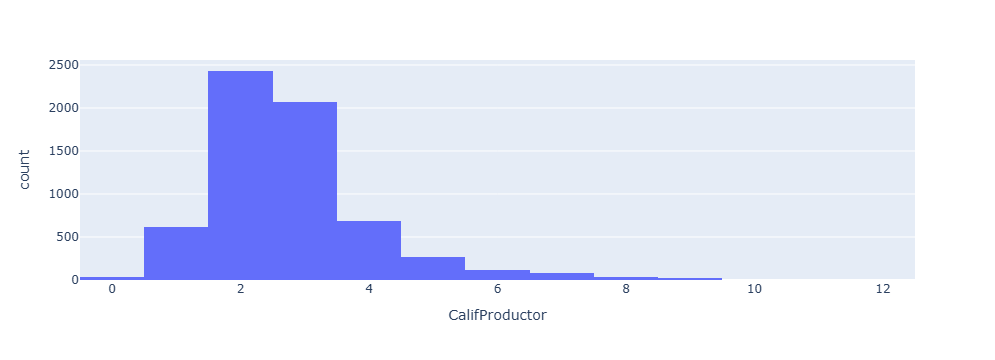

In [3]:
import plotly.express as px
import seaborn as sns
# Histograma de calificación del productor
fig = px.histogram(vinos, x="CalifProductor") 
#fig = sns.countplot(vinos,x="CalifProductor")
fig.show()


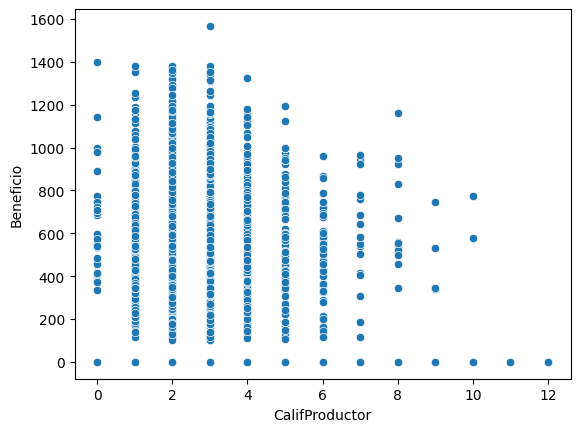

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()
sns.scatterplot(data=vinos, x="CalifProductor", y="Beneficio")#, hue="Compra")
#sns.boxplot(x='long',y='Luxury',data=viviendasDep,palette='viridis')
plt.show()

Por tanto, podemos adoptar la estrategia de mantener la variable continua por ese aspecto chi-cuadrado que no nos ha disgustado y, a su vez crear una variable categórica y posteriormente evaluar su distribución uniendo aquellas categorías minoritarias siempre con algún sentido, en este caso ordinal. Así tendremos las dos posibilidades para probar en los modelos de predicción que generemos.

Estas son posibles alternativas, en base a puro empirismo y un poco también porque se ve venir que dejar esa variable en un factor como pocas categorías que mantenga su poder predictivo es difícil tarea, decidimos mantenerla como continua.

### Conversión a factor de toda variable con menos de 10 valores distintos

Utilizamos el **.loc** para filtrar por condición sobre valores únicos de variables y creamos la lista de columnas que deberían pasar a factor. Posteriormente, se utiliza **astype** para pasar a categórica.


In [8]:
#to_factor

In [4]:
# Lista de columnas con menos de 10 valores distintos. Potenciales factores!
to_factor = list(vinos.loc[:,vinos.nunique() <= 10]);  

# Podemos cambiar el tipo de todas ellas a factor de una vez
vinos[to_factor] = vinos[to_factor].astype('category')


Vamos a contar el número de valores únicos de las variables numéricas por si nos hemos dejado algo por ahí. 



In [5]:
# Número de valores distintos por variable
vinos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   int64   
 1   Beneficio       6365 non-null   int64   
 2   Compra          6365 non-null   category
 3   Acidez          6365 non-null   float64 
 4   AcidoCitrico    6365 non-null   float64 
 5   Azucar          6365 non-null   float64 
 6   CloruroSodico   6066 non-null   float64 
 7   Densidad        6365 non-null   float64 
 8   pH              6170 non-null   float64 
 9   Sulfatos        5761 non-null   float64 
 10  Alcohol         6365 non-null   float64 
 11  Etiqueta        6365 non-null   category
 12  CalifProductor  6365 non-null   int64   
 13  Clasificacion   6365 non-null   category
 14  Region          6258 non-null   category
 15  PrecioBotella   6365 non-null   float64 
dtypes: category(4), float64(9), int64(3)
memory usage: 622.5 KB


En principio la única cosa rara es la variable Etiqueta que no debería tener tantos valores distintos.. 

### Descirptivos para las variables 


In [ ]:
# Número de valores distintos por variable
vinos.describe().round(1)

# Si quieres incluir todas
# vinos.describe(incluye='all').round(1) el problema es que al realizarlo saldrán los NaN, diferenciar continuas y categoritcas

,ID,Beneficio,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella
count,6365.0,6365.0,6365.0,6365.0,6365.0,6066.0,6365.0,6170.0,5761.0,6365.0,6365.0,6365.0
mean,8010.7,452.4,0.3,0.3,4718.7,0.1,1.0,3.2,0.5,16.3,2.8,2.6
std,4654.9,308.4,0.8,0.9,21192.5,0.3,0.0,0.7,0.9,25.6,1.3,1.5
min,2.0,0.0,-2.8,-3.2,-127.1,-1.2,0.9,0.5,-3.1,-4.5,0.0,1.0
25%,3980.0,236.0,0.1,0.0,0.9,-0.0,1.0,3.0,0.3,9.0,2.0,1.4
50%,8065.0,480.0,0.3,0.3,5.0,0.0,1.0,3.2,0.5,10.5,3.0,2.2
75%,12027.0,671.0,0.6,0.6,22.6,0.1,1.0,3.5,0.9,12.8,3.0,3.4
max,16128.0,1568.0,3.7,3.9,99999.0,1.4,1.1,6.0,4.2,150.0,12.0,11.4


Distintas formas de echar el vistazo a las distribuciones de las variables, donde prestaremos atención al *describe* que nos informa sobre cuartiles y media, así como valores perdidos y máximos. Así, observamos que *azucar* tiene valores 99999 sospechosos y *sulfatos* 604 valores ausentes (NA), que alcohol debe tener distribución asimétrica positiva por valores posiblemente altos, de hecho es un % y no debería superar 100. 

Podemos sacar los descriptivos básicos para las categóricas.


In [ ]:
# Número de valores distintos por variable, sólo te da las categoricas
vinos.describe(exclude=np.number)


,Compra,Etiqueta,Clasificacion,Region
count,6365,6365,6365,6258.0
unique,2,10,5,3.0
top,1,R,**,3.0
freq,4998,2380,1754,2132.0


### Inspección gráfica

Podemos inspeccionar las distribuciones gráficamente para completar la exploración. En este punto, nos podemos plantear la creación de un par de funciones gráficas que nos faciliten el trabajo, de tal forma que las podamos aplicar al dataset completo para visualizarlo de un plumazo. 

En primer lugar, como me gusta ver el histograma y el boxplot en relación para cada variable, vamos a definir una función que nos saque ambos gráficos jusntos. Podríamos adoptar varias formas de pensar de cara a la programación, por flexibilidad, decidimos que la función trabaje sobre una potencial columna o variable, así podremos aplicarla a todas o parte de las columnas del dataset.


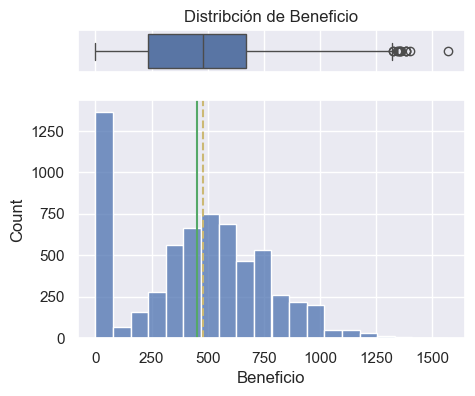

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(5,4), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data),color='g',linestyle='-')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data),color='y',linestyle='--')
    # Asignar título y nombre de eje si tal
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title, xlabel="")
    # Mostrar gráfico
    plt.show()

histogram_boxplot(vinos['Beneficio'], bins = 20, font_scale=1, title="Distribción de Beneficio")


Seguidamente vamos a implementar una función sencilla para sacar un barplot (aquí podéis indagar posibilidades de otros paquetes de visualización para *customizar* vuestros informes al gusto). Vamos a tirar de plotly a ver..



In [14]:
def cat_plot(col):
     if col.dtypes == 'category':
        fig = px.bar(col.value_counts())
        #fig = sns.countplot(x=col)
        return(fig)

# Aplicación a una variable en particular    
cat_plot(vinos.Compra)


In [15]:
# Variable Etiqueta
cat_plot(vinos.Etiqueta)


Una vez definidas las funciones para gráficos de variables numéricas y nominales, podemos integrar el proceso en una sola función que pueda ser aplicada a todas o parte de las columnas y distinga el tipo de las mismas para escoger el gráfico adecuado y mostrarlo.



Cont


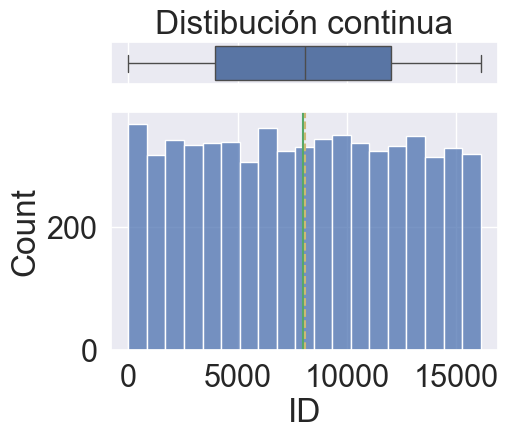

Cont


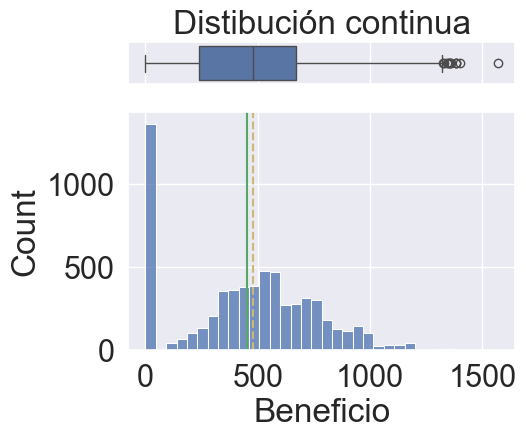

Cat


Cont


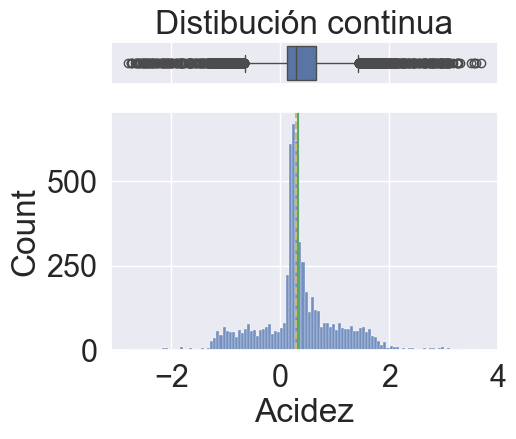

Cont


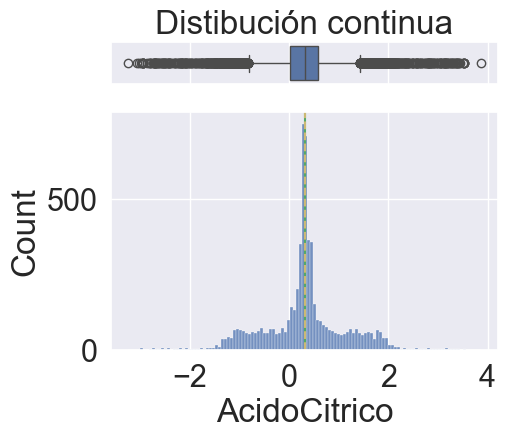

Cont


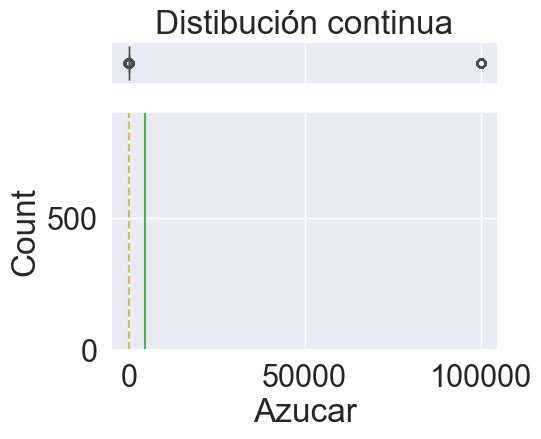

Cont


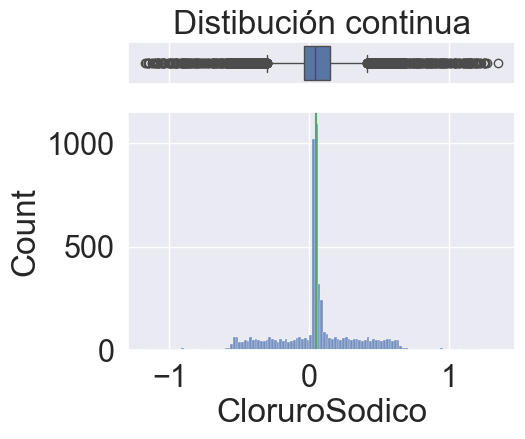

Cont


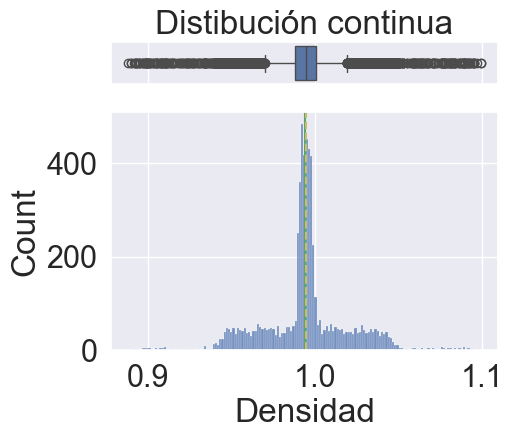

Cont


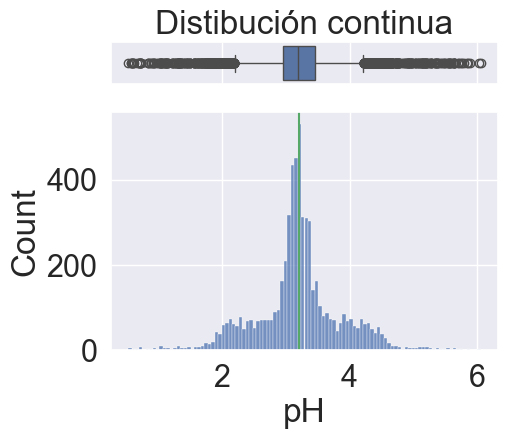

Cont


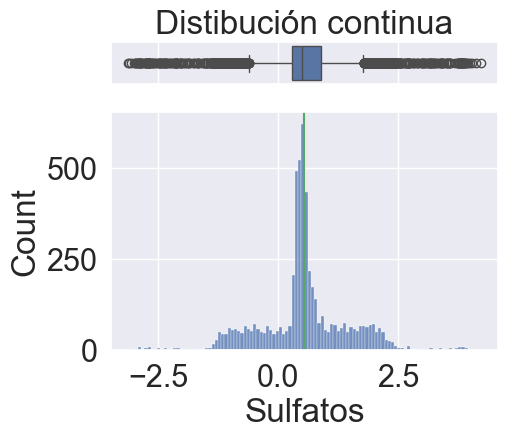

Cont


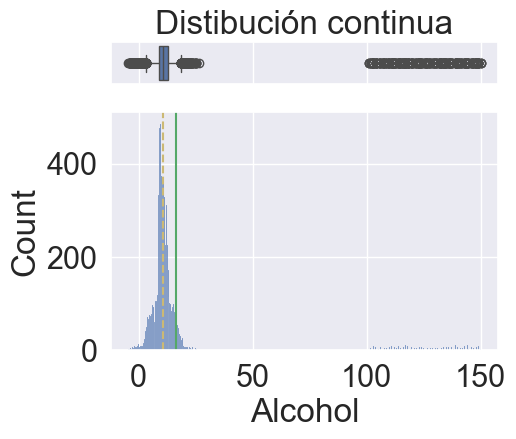

Cat


Cont


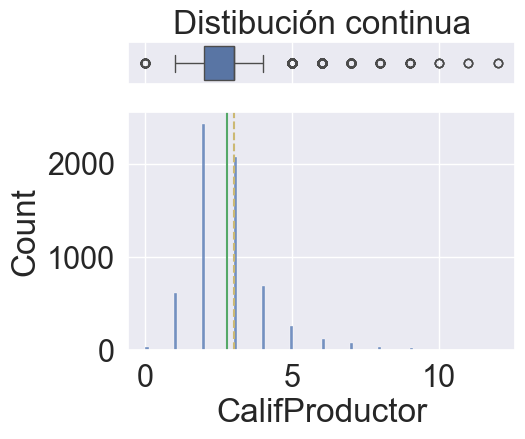

Cat


Cat


Cont


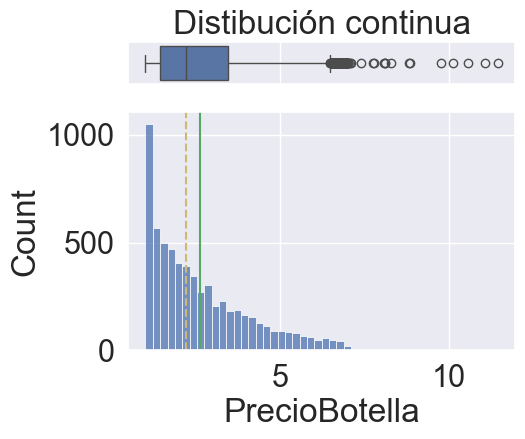

ID                None
Beneficio         None
Compra            None
Acidez            None
AcidoCitrico      None
Azucar            None
CloruroSodico     None
Densidad          None
pH                None
Sulfatos          None
Alcohol           None
Etiqueta          None
CalifProductor    None
Clasificacion     None
Region            None
PrecioBotella     None
dtype: object

In [16]:
def plot(col):
     if col.dtypes != 'category':
        print('Cont')
        histogram_boxplot(col, xlabel = col.name, title = 'Distibución continua')
     else:
        print('Cat')
        cat_plot(col).show()
        
# Aplicar a una serie de columas 1:9 del data
vinos.apply(plot)


## Corrección de errores detectados

1. *Etiqueta* tiene 10 categorías y debería tener 5. Hacemos una tabla de frecuencias de las categorías para indagar.


In [17]:
# Tabla de frecuencias
vinos.Etiqueta.value_counts()


Etiqueta
R     2380
M     1357
B     1282
r      420
m      230
MM     216
b      209
MB     191
mb      40
mm      40
Name: count, dtype: int64

Parece que hay mayúsculas y minúsculas. Habrá que unificar para que la variable tenga sentido. Lo más inmediato es pasar a mayúsculas o minúsculas todo y sencillamente se arreglará. 

Podemos utilizar el apply con lambda para ver cómo quedaría el cambio (también podríamos utilizarlo para cambiarlo asignando a la variable y "pisando" la información)


In [18]:
#vinos['Etiqueta'].upper()

In [10]:
# Utilizar apply con lambda para ver como quedaría el cambio
vinos['Etiqueta']=vinos['Etiqueta'].apply(lambda x: x.upper()).astype('category')


Tiene buena pinta. Podemos hacer el cambio sencillamente con operaciones sobre cadenas de caracteres de pandas *.str* y la función *upper()* para transformación en mayúsculas. 



In [20]:
# Realizar el cambio en la propia variable y cambiar el tipo a categórica
vinos['Etiqueta'] = vinos['Etiqueta'].str.upper().astype('category')


Ya que estamos con motivación, vamos a reordenar el factor para que MM sea el primer nivel o el más bajo y MB sea el último, manteniendo la naturaleza ordinal de la variable. 



In [11]:
# Vamos a ordenar el factor como nos gustaría tenerlo
vinos["Etiqueta"] = vinos["Etiqueta"].cat.reorder_categories(['MM','M','R','B','MB'])

# A ver como está el tema ahora
vinos.Etiqueta.value_counts()


Etiqueta
R     2800
M     1587
B     1491
MM     256
MB     231
Name: count, dtype: int64

La tabla de frecuencia de *value_counts()* ordena por defecto las categorías por volumen de registros o frecuencia, pero siempre podemos decirle que no lo haga, con lo que mostrará el orden original del factor. 



In [22]:
# Tabla de frecuencias sin ordenar por volumen
vinos.Etiqueta.value_counts(sort=False)


Etiqueta
MM     256
M     1587
R     2800
B     1491
MB     231
Name: count, dtype: int64

2. **Azucar**. Tiene un gráfico directamente ilegible...está claro que hay un NA no declarado con valor 99999. Hay que reemplazarlo por un verdadero missing. En python, podemos asignar un valor missing con la función nan de numpy. Al realizar el cambio con la filosofía inplace, se pisa la información original en la columna del dataset. 

Cuidado con utilizar esto cuando no tenemos muy claro que el cambio es correcto!! Habría que volver atrás a datos brutos y volver a ejecutar.. que bueno, por otro lado es gratis, pero mejor para pruebas trabajar con copias o con inplace=False.


In [12]:
# Quitamos ese 99999 de la variable Azucar y lo pasamos a NA
vinos.Azucar.replace(99999,np.nan,inplace=True)

# Comprobamos el nuevo máximo
vinos.Azucar.min(),vinos.Azucar.max()


C:\Users\Guille\AppData\Local\Temp\ipykernel_14308\2972985998.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





(-127.1, 141.15)

3. **Alcohol**. La tabla de info de las variables nos dice que es un % y debe estar por tanto restringido al rango 0-100. Todo valor fuera de ese rango habrá que tomarlo como valor perdido pues no podemos asignar claramente a otros valores en principio. Aquí podemos utilizar el *where* de numpy o bien el *between* de pandas.



In [13]:
# Corregimos valores fuera de rango de Alcohol (recordemos que es un %). Opción con np.where de nuumpy
#vinos.Alcohol = np.where((vinos['Alcohol'] < 0) | (vinos['Alcohol'] >100), np.nan,vinos.Alcohol)

# Opción con .loc de pandas
vinos.loc[~vinos.Alcohol.between(0, 100), "Alcohol"] = np.nan

# Comprobamos nuevos límites de la variable
vinos.Alcohol.min(),vinos.Alcohol.max()


(0.0, 26.5)

In [15]:
vinos.Alcohol.between(0, 100)

0       False
1        True
2        True
3        True
4        True
        ...  
6360     True
6361    False
6362     True
6363     True
6364     True
Name: Alcohol, Length: 6365, dtype: bool

4. **Clasificación**. Veíamos esa categoría ? que nos llama la atención. Veamos si se trata de algo residual y podemos pasar a missing para imputar posteriormente o si es una categoría con importancia en volumen y patrón frente al objetivo. 



In [26]:
# Frecuencias de las categorías de clasificación
print(vinos.Clasificacion.value_counts())

# Tabla de contingencia con la variable objetivo binaria Compra
pd.crosstab(index=vinos['Compra'], columns=vinos['Clasificacion'])


Clasificacion
**      1754
?       1680
*       1535
***     1074
****     322
Name: count, dtype: int64


Clasificacion,*,**,***,****,?
Compra,,,,,
0,306,46,0,0,1015
1,1229,1708,1074,322,665


Reemplazar los ? por Desconocido pues representa una categoría importante en volumen y con un posible patrón interesante ante la variable objetivo. Se intuye que los vinos de clasificación desconocida tienen bastante menor probabilidad de compra! utilizamos el *replace* para la tarea de cambio de valores.



In [16]:
# Reemplazar los ? por Deconocido pues representa una categoría importante en volumen y con un posible patrón interesante
vinos.Clasificacion.replace('?','Desc',inplace=True)


C:\Users\Guille\AppData\Local\Temp\ipykernel_14308\3657064103.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Guille\AppData\Local\Temp\ipykernel_14308\3657064103.py:2: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



Una vez libres de errores graves, las variables están preparadas para la gestión de outliers y missing. Para ello, es importante separa las variables objetivo y trabajar en el archivo de predictores. No es habitual tocar las variables objetivo puesto que representan nuestra verdad verdadera, son las variables de supervisión y se presuponen bien recogidas. 

Imaginemos que se nos presenta la situación en la que tenemos valores missing en las objetivo, que deberíamos hacer? Pues tratar estas instancias como un conjunto de test sobre el que podríamos hacer predicciones y valorar si el modelo parece tener sentido. El problema es que no podremos evaluar la calidad de las estimaciones mediante el error cometido puesto que no tenemos su verdad verdadera. Serían como instancias de un verdadero test futuro! Aquí utilizamos asignación de las objetivo a un objeto externo al data frame y luego el borrado de las variables del data. En este caso utilizamos *drop* pero seguramente podríamos usar *remove* en su lugar. 


In [17]:
vinos.Region.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6365 entries, 0 to 6364
Series name: Region
Non-Null Count  Dtype   
--------------  -----   
6258 non-null   category
dtypes: category(1)
memory usage: 6.5 KB


In [18]:
# Renombrar categorías de Región
new_categories = ["Reg %s" % round(g) for g in vinos.Region.cat.categories]

vinos.Region = vinos.Region.cat.rename_categories(new_categories)


In [19]:
#Indico la variableObj, el ID y las Input 
# los atípicos y los missings se gestionan sólo de las input
varObjCont = vinos.Beneficio
varObjBin = vinos.Compra
imput = vinos.drop(['Beneficio','Compra'],axis=1)

imput.head()


,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,Etiqueta,CalifProductor,Clasificacion,Region,PrecioBotella
0,2,0.16,-0.81,26.10,-0.425,1.02792,3.38,0.70,NaN,M,2,***,Reg 1,1.00
1,4,2.64,-0.88,14.80,0.037,0.99518,3.12,0.48,22.0,M,3,***,Reg 3,3.38
2,8,0.29,-0.40,21.50,0.060,0.99572,3.49,1.21,10.3,R,3,Desc,Reg 1,3.72
3,11,-1.22,0.34,1.40,0.040,1.03236,3.20,NaN,11.6,B,2,***,Reg 2,6.23
4,12,0.27,1.05,11.25,-0.007,0.99620,4.93,0.26,15.0,R,1,Desc,Reg 2,2.44


# Valores atípicos 

Para facilitarnos la vida y complementar la idea que tenemos ya sobre las distribuciones de las variables, llevamos a cabo un conteo de los valores que se consideran extremos según un consenso de dos criterios distintos. En primer lugar, se distingue variable simétrica o posiblemente no, para aplicar *media + 3 sd* ó *mediana + 8 mad*, respectivamente. Recordamos en este punto que todas las medidas de dispersión basadas en la mediana o cuartiles son muy poco sensibles a la presencia de asimetría en la distribución, siendo por ello más fiables en este caso. Por otro lado, aplicamos el clásico criterio del boxplot umbrales en *cuartil1 - 3IQR* y *cuartil3+ 3IQR*. 

Para aclarar, veamos un momento las asimetrías de las variables numéricas.


In [59]:
#vinos.select_dtypes(include=np.number).apply(lambda x: x.skew())

imput.select_dtypes(include=np.number).skew()

ID                0.003339
Acidez            0.029079
AcidoCitrico     -0.024261
Azucar            0.022391
CloruroSodico     0.012041
Densidad         -0.009353
pH                0.003311
Sulfatos         -0.062373
Alcohol           0.267099
CalifProductor    1.663553
PrecioBotella     1.120795
dtype: float64

Asimetrías en valor absoluto mayores a la unidad son signo de distribución significativamente sesgada a la derecha/positiva (+) o izquierda/negativa (-). 


Antes de gestionar aquellos valores detectados como outliers, valoramos la incidencia en cada variable contando el porcentaje de registros atípicos en relación al total de registros. Con ello, evaluamos si estamos ante un problema grave (tener más de un 20% de valores atípicos en alguna variable es síntoma de distribución bimodal, hay en realidad dos poblaciones jugando en la distribución) o si por el contrario, se trata de un % bajo con el que podamos lidiar sin graves consecuencias en las distribuciones de las variables. 

Vamos a crear una **función gestiona_outliers** para facilitar el trabajo en este sentido. La idea es tener una sola función que implemente:

1- **Visualización de la incidencia** de outliers --> Toma de decisiones

2- **Gestión** de los mismos: 

  2.1- **Winsorizar**: Colapsar todo valor mayor o menor que los umbrales de cierto rango (dado por percentiles habitualmente) para igualarlo con esos umbrales. Como ya comentábamos, este método conserva la integridad del datos en el sentido de que si era muy grande por la derecha ahora estará en el extremo, pero puede provocar carga excesiva de las colas de la distribución, generando quizá algunas rarezas en picos de densidad.. 
  
  2.2- **Convertir en NAs**: Asumiendo que los valores extremos son inaceptables (es decir, se sospecha que no puede ser tan alto o bajo por alguna razón). Podríamos pensar en que sea un fallo y por tanto decidir pasar a missing esos valores para luego gestionarlos con los valores perdidos. Esta técnica podría incurrir en errores graves de cambio del sentido de la información. Por ejemplo, en este caso un vino muy caro, pero que es un vino real y ese es su precio, es lo que hay...bueno considerando que es erróneo, pasamos a Na e imputamos por media o valor aleatorio, quedando este valor de precio en un entorno central...tal vez hay características que generaban un patrón de precio alto que ahora serán mal aprendidas por el modelo... Hay que andarse con ojo con estas cosas.. 
  
En cualquier caso, ahí queda la función para utilizarla como se considere y tal vez incluir o desarrollar nuevas formas de tratamiento.. 


In [22]:
## Función manual de winsor con clip+quantile 
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))


In [23]:
from scipy import stats # Añadimos en este punto para cargar la librería que ahora hace falta

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>6 ## Cambio mad por median_abs_deviation!! 
     
     # Calcular primer cuartil     
     q1 = col.quantile(0.25)  
     # Calcular tercer cuartil  
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

          
# Llamada en modo check
imput.select_dtypes(include=np.number).apply(lambda x: gestiona_outliers(x))#.set_index(['Low','up','Tot'])


ID
Acidez
AcidoCitrico
Azucar
CloruroSodico
Densidad
pH
Sulfatos
Alcohol
CalifProductor
PrecioBotella


,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella
0,0.0,0.816968,0.848390,0.956307,0.807781,0.942655,0.794165,1.024128,0.000000,0.000000,0.000000
1,0.0,0.879811,0.785546,0.972795,0.873722,0.942655,0.696921,0.815831,0.317885,0.157109,0.078555
2,0.0,1.696779,1.633936,1.929101,1.681503,1.885310,1.491086,1.839958,0.317885,0.157109,0.078555


**NOTA DE CAMBIO EN FUNCIÓN gestiona_outliers** 

Nos han quitado la función MAD de pandas. Recurrimos entonces a scipy y su querido paquete stats para solventar este molesto inconveniente. Cambiamos simplemente *col.mad()* por *stats.median_abs_deviation(col)*

Como pequeño resumen, lo que buscamos con el tratamiento de outliers es identificar valores verdaderamente extremos y que no sea típicos, lo cual necesariamente implica que han de ser pocos!! Y esto es muy relevante. Si son el 20% de los registros...pues tal vez estamos ante dos poblaciones distintas... habría que abordar el problema de otra forma..tal vez tratar cada población por separado.

Es evidente que la búsqueda o gestión de outliers aplica únicamente a variables de tipo numérico por lo que podemos crear el subconjunto de estas variables, tratarlas y posteriormente volver a juntar con las categóricas sobre las que no aplica este análisis. 


In [24]:
# Crear copia para evitar pisar información
vinCont = imput.select_dtypes(include=np.number).copy()

# Aplicar la gestión de outliers en modelo winsor
vinos_winsor = vinCont.apply(lambda x: gestiona_outliers(x,clas='winsor'))

# Contemos si ha desaparecido algún resgitro o algo 
# vinos_winsor.apply(lambda x: x.isna().sum()/x.count()*100)


ID
Acidez
AcidoCitrico
Azucar
CloruroSodico
Densidad
pH
Sulfatos
Alcohol
CalifProductor
PrecioBotella


In [27]:
vinos_winsor.sort_values(by='Sulfatos').head()

,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella
2476,6260,-1.03,0.42,11.4,0.184,1.02334,3.18,-2.32,9.1,2,2.18
4511,11325,-0.05,-0.17,-9.4,0.408,0.99992,2.61,-2.32,9.5,2,3.01
6073,15351,0.26,0.56,9.1,-0.395,0.96857,1.98,-2.32,11.0,2,2.04
4713,11872,-0.81,0.46,NaN,0.086,0.99702,2.25,-2.32,9.0,3,2.11
321,737,0.31,1.37,1.4,-0.079,0.92405,3.12,-2.32,12.2,3,1.96


In [36]:
# Veamos los valores mínimos de acidez ahora
vinos_winsor.iloc[2608,:]
#.sort_values(by='Sulfatos').head()


ID                6573.00000
Acidez               0.56000
AcidoCitrico         0.39000
Azucar               1.00000
CloruroSodico       -0.05100
Densidad             0.95483
pH                       NaN
Sulfatos            -2.32000
Alcohol             12.20000
CalifProductor       2.00000
PrecioBotella        5.15000
Name: 2608, dtype: float64

In [30]:
# Veamos los valores mínimos de acidez ahora
vinos_winsor.sort_values(by='Acidez').head()


,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella
3529,8900,-2.05,-0.75,-15.8,0.089,1.01463,3.49,0.62,10.8,1,2.37
3822,9593,-2.05,0.82,7.0,0.046,0.99454,4.53,0.70,10.4,2,1.75
945,2344,-2.05,0.20,47.0,0.486,0.98456,3.38,-0.08,9.4,3,3.43
2516,6352,-2.05,-0.09,-32.5,-0.569,0.94870,3.31,0.42,13.7,2,3.56
5768,14573,-2.05,-1.96,9.7,-0.165,0.99610,3.42,NaN,11.5,3,1.31


Recordemos que la búsqueda de outliers atañe en exclusiva a las variables numéricas por lo que el archivo de salida no tiene los factores. Vamos a juntar numéricas y factores en un solo archivo para valorar la incidencia de perdidos en el conjunto completo. 



In [31]:
# Juntar columnas con join
imput_wins = vinos_winsor.join(imput.select_dtypes(exclude=np.number))
imput_wins

,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,Etiqueta,Clasificacion,Region
0,2,0.16,-0.81,26.10,-0.425,1.02792,3.38,0.70,NaN,2,1.00,M,***,Reg 1
1,4,2.64,-0.88,14.80,0.037,0.99518,3.12,0.48,22.0,3,3.38,M,***,Reg 3
2,8,0.29,-0.40,21.50,0.060,0.99572,3.49,1.21,10.3,3,3.72,R,Desc,Reg 1
3,11,-1.22,0.34,1.40,0.040,1.03236,3.20,NaN,11.6,2,6.23,B,***,Reg 2
4,12,0.27,1.05,11.25,-0.007,0.99620,4.93,0.26,15.0,1,2.44,R,Desc,Reg 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6360,16111,0.39,0.17,2.30,0.099,1.00223,4.28,0.12,9.8,4,1.28,R,*,Reg 1
6361,16112,0.69,0.09,53.90,0.044,0.99480,3.55,NaN,NaN,2,4.19,MB,***,Reg 3
6362,16113,0.33,-0.94,-42.50,0.036,0.97287,2.99,NaN,14.0,4,1.81,R,**,Reg 1
6363,16127,0.17,-1.10,37.00,0.078,0.99076,3.25,NaN,12.3,1,1.00,R,**,Reg 2


Muchas alternativas disponibles, lo importante es conocer las fortalezas y debilidades de cada uno y aplicarlo con lógica según resulte más conveniente para los datos que manejamos. 

# Valores perdidos 

Entramos de lleno en la segunda gran gestión que debemos llevar a cabo antes de la modelización. Los archiconocidos valores perdidos. En primer lugar comentar que, llegados a este punto tenemos valores perdidos de dos fuentes distintas, por una parte los que vienen "de serie" en el dataset que podemos asociar a falta de medida en la recogida de los datos y aquí existe toda una teoría sobre los mecanismos de aparición de dichos missing, completamente al azar (MCAR), al azar(MAR) o nada de azar y existe patrón (MNAR). 

Dejo por aquí un poco más de información y diversos métodos propuestos para la imputación de estos valores. 

https://stefvanbuuren.name/fimd/sec-MCAR.html

Nuestro objetivo, en este limitado módulo, será valorar la incidencia de los valores perdidos y conocer los métodos usuales de imputación univariante (cada variable independientemente de las otras) con sus pros y contras. 

Que podemos hacer con los missings? 

1) **Eliminar u omitir del dataset**

Eliminar "por lista" los Nas, es decir, eliminar del dataset toda observación con al menos un NA en al menos 1 variable. Se consigue liberar el dataset de perdidos (algunas técnicas y análisis no permiten su inclusión) pero se puede incurrir en los problemas que comentamos en el siguiente punto. 

2) **Nada** 

Podemos obviar la presencia de valores perdidos y ya el modelo se encargará de quitarlos "por lista", es decir, eliminar del análisis toda observación con al menos un NA en el set de variable escogido (importante este punto! si elegimos un modelo con las variables v1:v5, no se eliminarán los registros completos en estas variables pero con perdidos en v6:v10, he aquí la diferencia con la omisión de missings de primeras para todo el archivo). Esto es habitual y se puede hacer, ahora bien no está exento de peligros. Veamos.

- Peligro de los **missings cruzados**. Imaginamos el caso en que tenemos 10 variables y 100 registros y cada una de ellas tiene un 5% de perdidos...No parece mucho con lo cual los quitamos por lista. Nuestro pensamiento es 5% pero, si se da el caso de que los NA de cada variable aparecen en registros distintos...entonces tenemos 5*10= 50% de los registros con al menos un perdido...hemos perdido la mitad de la información!!! 

- **Sesgo** por valores perdidos. El simple hecho de eliminar observaciones por el mero hecho de que presenten perdidos puede introducir un importante sesgo de selección de registros en los modelos. Imaginemos que la gente mayo tiende a no contestar ciertas preguntas en una encuesta, eliminamos y nos quedamos con muy poca gente mayor por lo que las conclusiones con toda seguridad estarán sesgadas hacia los jóvenes. 

3) **Imputar** sus valores. 

No queremos exponernos a lo anterior por lo que se puede adoptar la estrategia de asignar un valor a estos datos no conocidos. 

- **Imputación por valores centrales (media, mediana)**: Muy habitual asignar valores centrales ya que no alteran la distribución de las variables como tal. El gran inconveniente de este método es a subestimación de la verdadera varianza de la variable ya que estamos centrando demasiado la distribución haciendo que artificialmente su varianza se reduzca, en ocasiones muy drásticamente. 

- **Imputación por valores aleatorios**: Si no queremos centrar tanto la distribución, podemos optar por asignar al azar valores observados de las distribuciones de cada variable a los registros con NA. De esta forma, cualquier valor en el rango observado puede ser asignado a los faltantes. El gran inconveniente de esto es la dependencia del azar.

- **Imputación por modelos multivariantes**: Muchas opciones en este apartado. Existen métodos que tienen en cuenta los valores observados de otras variables para asignar el valor más "plausible" a la variable perdida en un sentido conjunto. Una de las alternativas es generar imputaciones por un modelo de regresión por ejemplo, así para imputar Azucar utilizaremos un modelo que estime los valores de azucar en base a las demás variables (que se ajustará con los valores validos por lista) y posteriormente predeciremos los perdidos de azucar mediante este modelo generado. De esta misma forma existen modelos de imputación por random forest (missforet), vecinos más cercanos (knn), cadenas de Markov (hmisc, amelia) y gran cantidad de aproximaciones de imputación múltiple (imputar n veces y promediar). El mayor problema de estos métodos suele radicar en el posible sobreajuste a los datos de training. 


El primer paso es valorar la incidencia de los valores perdidos ya que si no representan gran proporción, no existe gran peligro de cambio en la distribución de las variables con independencia del método utilizado para la imputación.  

## Incidencia 

Vamos a actuar por dos vías, filas y columnas para contar el % de perdidos en cada registro y en cada variable. Con esta información tomaremos decisiones sobre gestión. 


- **Missings por variable**.

Calculamos el porcentaje de registros que se encuentran perdidos por cada variable conel objetivo de valorar la incidencia por columnas. Hay variables que tienen demasiada información perdida? Digamos que si % de missing en una variable es >50%, "inventarse" la mitad de la información de esa variable tiene un riesgo altísimo de provocar sesgos en el futuro modelo predictivo y tal vez sería mejor idea eliminarla. 


In [32]:
#Proporción de missings por variable 
imput_wins.apply(lambda x: x.isna().sum()/imput_wins.shape[0]*100)


ID                0.000000
Acidez            0.000000
AcidoCitrico      0.000000
Azucar            4.713276
CloruroSodico     4.697565
Densidad          0.000000
pH                3.063629
Sulfatos          9.489395
Alcohol           6.095837
CalifProductor    0.000000
PrecioBotella     0.000000
Etiqueta          0.000000
Clasificacion     0.000000
Region            1.681068
dtype: float64

Controlado esto, vemos que sulfatos es la variable más peligrosa con casi un 10% de perdidos..Digamos que es la variable en la que mayores dudas tenemos respecto a la conservación de su distribución tras la imputación. Por lo demás, valores relativamente bajos. 


- **Missings por observación**.

Calcularemos ahora el % de missings por observación y vamos a aplicar un truquillo que a veces nos ayuda mucho a controlar las imputaciones. Se trata de generar una variable en el archivo que cuanta la proporción de perdidos que tiene cada registro. De esta forma, siempre tenemos una huella de los registros con alta carga de imputaciones por si necesitamos saber algo sobre ellos en la etapa de modelado. Es más, esta será una variable que incluiremos en el modelo para valorar si puede generar un patrón de comportamiento respecto a la variable objetivo. 


In [34]:
#Proporción de missings por observación (como una nueva columna del dataset)
imput_wins['prop_missings'] = imput_wins.apply(lambda x: x.isna().sum()/imput_wins.shape[1]*100,axis=1)

# Valoramos distribución
imput_wins.prop_missings.describe()


count    6365.000000
mean        1.982718
std         3.541585
min         0.000000
25%         0.000000
50%         0.000000
75%         6.666667
max        20.000000
Name: prop_missings, dtype: float64

Vamos a ordenar el archivo por la nueva variable creada para ver el aspecto.



In [35]:
imput_wins.sort_values(by='prop_missings', ascending=False).head()



,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,Etiqueta,Clasificacion,Region,prop_missings
2781,6990,1.40,0.30,NaN,NaN,1.04263,4.00,NaN,15.1,3,1.30,R,**,Reg 2,20.0
1344,3341,0.26,0.27,18.2,0.048,1.04227,NaN,NaN,3.8,1,2.62,B,**,NaN,20.0
5402,13598,-0.45,0.26,NaN,NaN,0.99907,2.21,0.68,NaN,3,3.10,M,Desc,Reg 1,20.0
4385,11020,0.27,-0.01,NaN,0.295,0.99566,NaN,-0.46,NaN,3,2.35,R,**,Reg 2,20.0
1352,3357,1.02,1.51,NaN,NaN,0.99300,3.37,0.55,11.5,2,1.60,MB,Desc,NaN,20.0


Se puede observar que la incidencia por registro no escandalosa teniendo algo así como un máximo de 3 variables perdidas por registro, asequible. 

Es importante saber que, en el caso de decidir eliminar registros con gran cantidad de variables perdidas y por tanto incurrir en el borrado de filas del dataset, tenemos que aplicar el mismo filtro a las variables objetivo para que al unir el input depurado con ellas, los registros cuadren! 


## Coexistencia y patrones de missings

Podemos echar un vistazo a la correlación en la existencia de missings para valorar si existe algún patrón de aparición de los mismos. En caso de que observemos patrones de aparición, podemos tirar del hilo e indagar el porqué de ese comportamiento para decidir el método más adecuado para imputar. 

Hay un paquete disponible llamado **missingno** que implementa un par de funciones gráficas interesantes para la detección de patrones de co-aparición de los valores perdidos en diferentes variables. 


<Axes: >

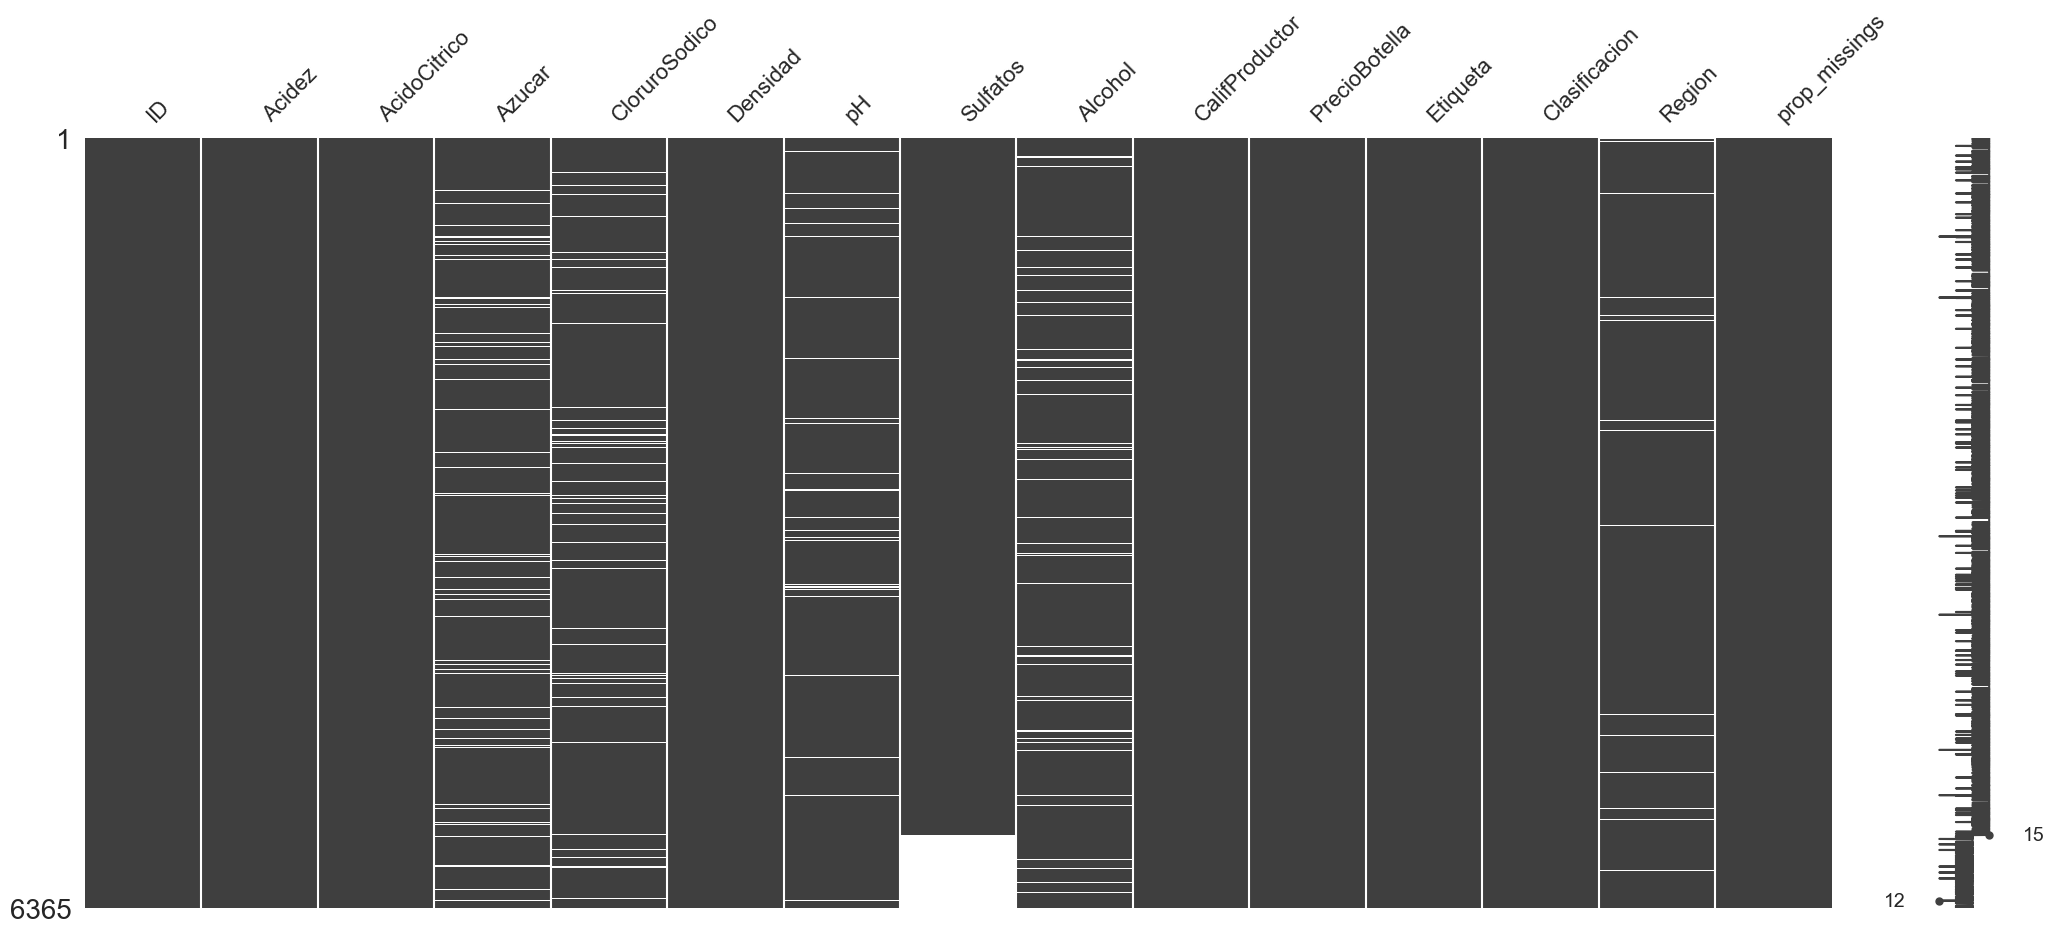

In [38]:
 
#!pip install missingno
import missingno as msno   

# Plot correlation heatmap of missingness
msno.matrix(imput_wins.sort_values(by='Sulfatos'))


No se intuyen patrones de aparición de missings con facilidad.  

Veamos esto en el mapa de calor que representa el valor de correlación en la matriz 0-1 de aparación o no de perdidos en cada registro-variable. Si la correlación es alta, significa que es probable encontrar perdidos en los mismos registros para esas dos variables, con lo cual habría un patrón de coexistencia y el peligro de sesgos debidos a los valores perdidos sería mayor. 


<Axes: >

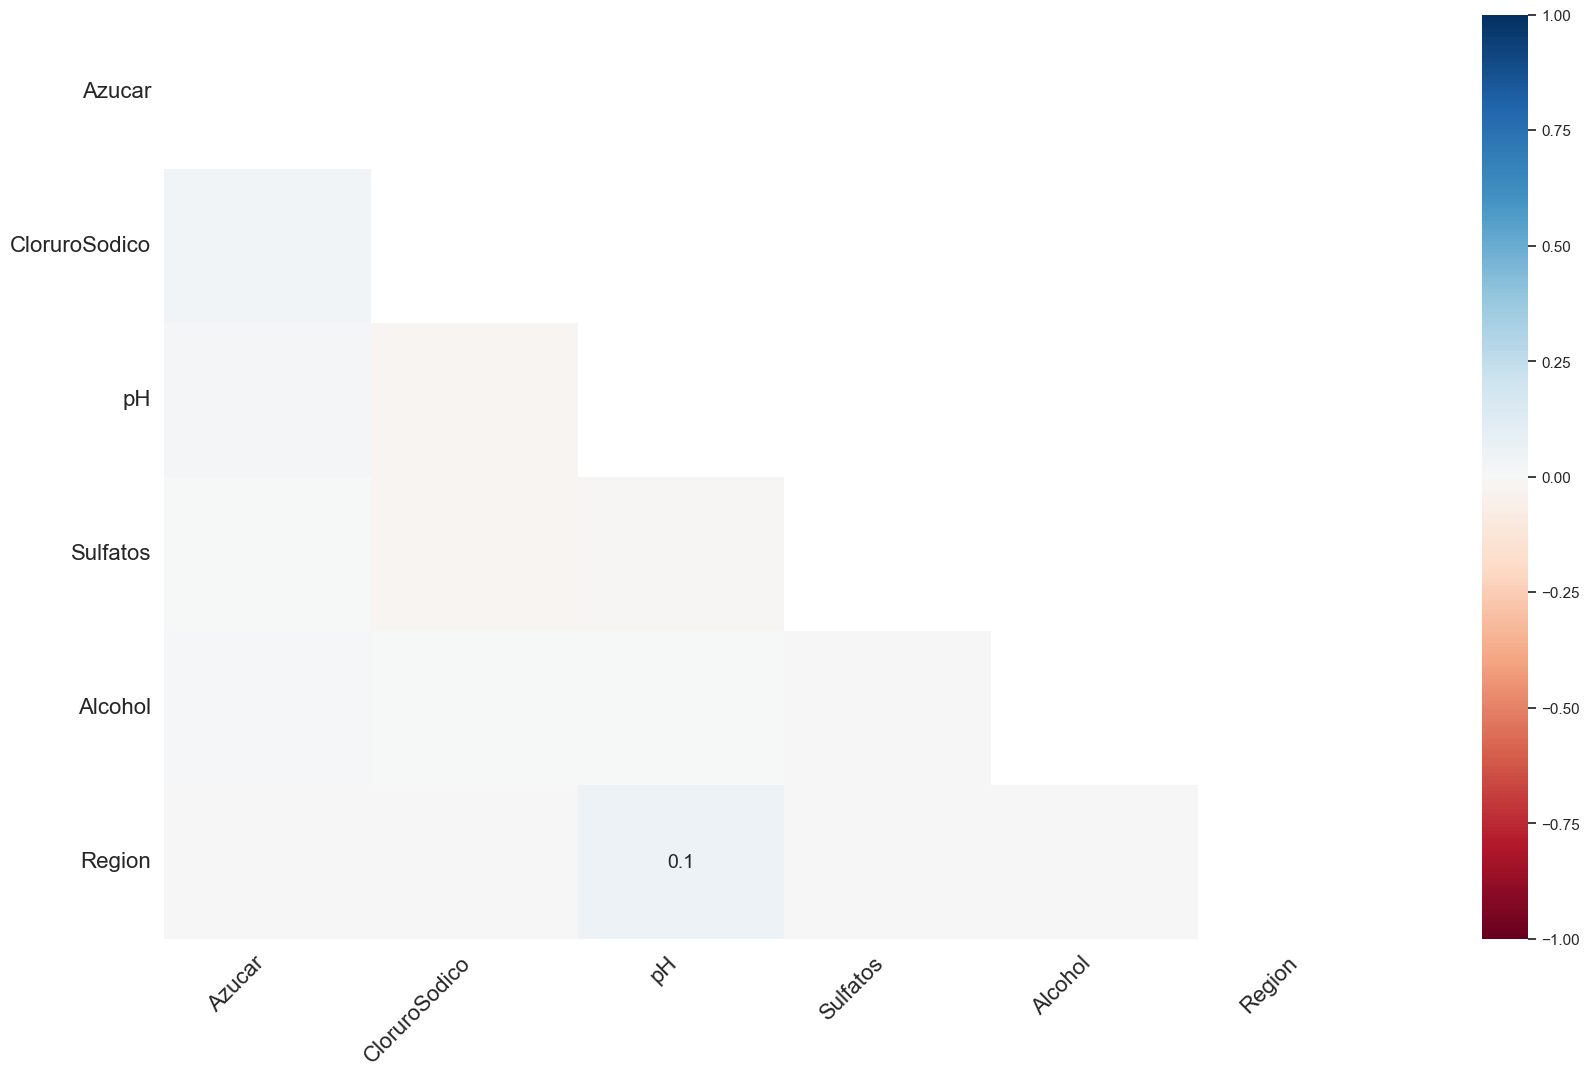

In [39]:
msno.heatmap(imput_wins)



Relaciones muy débiles con ese máximo de 0.1 para pH con Región. Nada destacable. 

## Imputaciones

Llegados a este punto, hemos comprobado que la incidencia de valores perdidos no es preocupante en general (con sulfatos con ese 10% que nos invita a estar atentos) por lo que vamos a decidirnos por la imputación de los datos de cara a mantener la mayor base muestral posible para el ajuste de los futuros modelos a los datos. 

Nos puede la curiosidad y nos planteamos que pasaría si elimináramos los NAs por lista del dataset. Cuantas observaciones perderíamos? Las variables que mayor carga de perdidos presentan, son realmente relevantes para un posible modelo? 


In [40]:
imput_wins.dropna().info()



<class 'pandas.core.frame.DataFrame'>
Index: 4692 entries, 1 to 6360
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              4692 non-null   int64   
 1   Acidez          4692 non-null   float64 
 2   AcidoCitrico    4692 non-null   float64 
 3   Azucar          4692 non-null   float64 
 4   CloruroSodico   4692 non-null   float64 
 5   Densidad        4692 non-null   float64 
 6   pH              4692 non-null   float64 
 7   Sulfatos        4692 non-null   float64 
 8   Alcohol         4692 non-null   float64 
 9   CalifProductor  4692 non-null   int64   
 10  PrecioBotella   4692 non-null   float64 
 11  Etiqueta        4692 non-null   category
 12  Clasificacion   4692 non-null   category
 13  Region          4692 non-null   category
 14  prop_missings   4692 non-null   float64 
dtypes: category(3), float64(10), int64(2)
memory usage: 490.8 KB


Nos quedamos con 4692 registros en total para todas las variables, lo que supone un 73% de la información del archivo. Nos hemos cargado el 27% de registros.. 

Como veremos cuando estudiemos las relaciones con las variables objetivo, en este dataset, las variables numéricas o características químicas (todas esas distribuciones super apuntadas) no generan especial patrón con las objetivo por lo que no serán predictores relevantes. Si nos cargamos ahora información en base a sus faltantes estaremos limitando o sesgando la capacidad del modelo (que seguramente no contenga a estas variables y pueda utilizar esos registros) por disminución (además no aleatoria) de base muestral. 

Conclusión, imputemos! 

Vamos a explorar algunas posibilidades de los paquetes *sklearn* y *feature_engine* para imputaciones simples y multivariantes de varios tipos. 

Definiremos los imputadores disponibles y posteriormente los aplicaremos a los datos.


In [41]:
import sklearn.impute as skl_imp
from sklearn.experimental import enable_iterative_imputer
#!pip install feature-engine

# Moda: Solo nominales
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

# knn: Solo numéricas
imputer_knn = skl_imp.KNNImputer(n_neighbors=3)

# Chain equations: solo numéricas
imputer_itImp = skl_imp.IterativeImputer(max_iter=10, random_state=0)

#conda install feature_engine
import feature_engine.imputation as fe_imp

# Aleatoria: numéricas y nominales
imputer_rand = fe_imp.RandomSampleImputer()

# Mediana: solo numéricas
imputer_median = fe_imp.MeanMedianImputer(imputation_method='median')

# Media: solo numericas
imputer_mean = fe_imp.MeanMedianImputer(imputation_method='mean')

!python -V

Python 3.11.10


Separaremos el dataset de nuevo en continuas y categóricas para aplicar los métodos que correspondan. 



In [43]:
imput_wins_cont = imput_wins.select_dtypes(include=np.number)
imput_wins_cat = imput_wins.select_dtypes(exclude=np.number)
imput_wins_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              6365 non-null   int64  
 1   Acidez          6365 non-null   float64
 2   AcidoCitrico    6365 non-null   float64
 3   Azucar          6065 non-null   float64
 4   CloruroSodico   6066 non-null   float64
 5   Densidad        6365 non-null   float64
 6   pH              6170 non-null   float64
 7   Sulfatos        5761 non-null   float64
 8   Alcohol         5977 non-null   float64
 9   CalifProductor  6365 non-null   int64  
 10  PrecioBotella   6365 non-null   float64
 11  prop_missings   6365 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 596.8 KB


### Posibilidades para las **numéricas**:

1. Nivel **univariante**

Comenzamos proponiendo métodos de imputación univariante que se basan en la información exclusiva de la distribución de la propia variable sin mirar a sus compañeras. En este plano, opciones ya comentadas como media, mediana o aleatorio. 


In [45]:
# Media
vinos_winsor_mean_imputed = imputer_mean.fit_transform(imput_wins_cont)#.transform(imput_wins_cont)
print(vinos_winsor_mean_imputed.describe())
print(vinos.describe())

# Mediana
vinos_winsor_median_imputed = imputer_median.fit(imput_wins_cont).transform(imput_wins_cont)
print(vinos_winsor_median_imputed.describe())

                 ID       Acidez  AcidoCitrico       Azucar  CloruroSodico  \
count   6365.000000  6365.000000   6365.000000  6365.000000    6365.000000   
mean    8010.702278     0.331342      0.315038     5.704650       0.051199   
std     4654.939139     0.769865      0.842346    32.810138       0.308632   
min        2.000000    -2.050000     -2.270000   -97.800000      -0.923000   
25%     3980.000000     0.130000      0.020000     0.900000      -0.004000   
50%     8065.000000     0.280000      0.310000     5.000000       0.048000   
75%    12027.000000     0.650000      0.580000    15.000000       0.124000   
max    16128.000000     2.730000      2.900000   109.900000       1.027000   

          Densidad           pH     Sulfatos      Alcohol  CalifProductor  \
count  6365.000000  6365.000000  6365.000000  6365.000000     6365.000000   
mean      0.994214     3.202263     0.527606    10.626351        2.760094   
std       0.025679     0.654400     0.881292     3.401016        1

In [46]:
vinos_winsor_mean_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              6365 non-null   int64  
 1   Acidez          6365 non-null   float64
 2   AcidoCitrico    6365 non-null   float64
 3   Azucar          6365 non-null   float64
 4   CloruroSodico   6365 non-null   float64
 5   Densidad        6365 non-null   float64
 6   pH              6365 non-null   float64
 7   Sulfatos        6365 non-null   float64
 8   Alcohol         6365 non-null   float64
 9   CalifProductor  6365 non-null   int64  
 10  PrecioBotella   6365 non-null   float64
 11  prop_missings   6365 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 596.8 KB


2. Nivel **multivariante**

Podemos explorar un par de posibilidades que se utilizan en el mundillo. Por una parte, las imputaciones basadas en la técnica de los k vecinos más cercanos (digamos que es un método espacial) que asocia valores promedio de los k vecinos más cercanos a la observación perdida pero jugando en el espación R^k siendo k el número de variables. Es decir, identifica registros parecidos en general en todas las variables (que estén cerca en ese hiperespacio), lo cual es una buena idea. El mayor problema que tiene es la dependencia del valor k (no hay consenso en este aspecto y depende de los datos) y el posible sobreajuste a los datos de training como cualquier otro método multi. 


In [47]:
imputer_knn.fit_transform(imput_wins_cont)

array([[ 2.00000000e+00,  1.60000000e-01, -8.10000000e-01, ...,
         2.00000000e+00,  1.00000000e+00,  6.66666667e+00],
       [ 4.00000000e+00,  2.64000000e+00, -8.80000000e-01, ...,
         3.00000000e+00,  3.38000000e+00,  0.00000000e+00],
       [ 8.00000000e+00,  2.90000000e-01, -4.00000000e-01, ...,
         3.00000000e+00,  3.72000000e+00,  0.00000000e+00],
       ...,
       [ 1.61130000e+04,  3.30000000e-01, -9.40000000e-01, ...,
         4.00000000e+00,  1.81000000e+00,  6.66666667e+00],
       [ 1.61270000e+04,  1.70000000e-01, -1.10000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  6.66666667e+00],
       [ 1.61280000e+04,  3.20000000e-01,  1.20000000e-01, ...,
         1.00000000e+00,  2.79000000e+00,  6.66666667e+00]])

In [48]:
# Fit/transform
imput_wins_knn_imputed = pd.DataFrame(imputer_knn.fit_transform(imput_wins_cont),columns=imput_wins_cont.columns)
imput_wins_itImp_imputed = pd.DataFrame(imputer_itImp.fit_transform(imput_wins_cont),columns=imput_wins_cont.columns)


In [49]:
imput_wins_itImp_imputed.describe()

,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,prop_missings
count,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000
mean,8010.702278,0.331342,0.315038,5.704936,0.051057,0.994214,3.203223,0.527612,10.626327,2.760094,2.610008,1.982718
std,4654.939139,0.769865,0.842346,32.810143,0.308633,0.025679,0.654467,0.881295,3.401030,1.310444,1.476877,3.541585
min,2.000000,-2.050000,-2.270000,-97.800000,-0.923000,0.914730,1.160000,-2.320000,0.000000,0.000000,1.000000,0.000000
25%,3980.000000,0.130000,0.020000,0.900000,-0.004000,0.988245,2.980000,0.330000,9.100000,2.000000,1.420000,0.000000
50%,8065.000000,0.280000,0.310000,5.000000,0.046361,0.994400,3.200000,0.521362,10.574275,3.000000,2.190000,0.000000
75%,12027.000000,0.650000,0.580000,15.000000,0.124000,1.000600,3.450000,0.770000,12.200000,3.000000,3.440000,6.666667
max,16128.000000,2.730000,2.900000,109.900000,1.027000,1.073900,5.260000,3.380000,22.700000,10.000000,9.770000,20.000000


### Posibilidades para las **nominales**:

Para las variables categóricas podemos utilizar moda (la categoría más representada) o aleatorio. 


In [50]:
imput_wins_moda_imputed = pd.DataFrame(imputer_moda.fit_transform(imput_wins_cat),columns=imput_wins_cat.columns)

imput_wins_moda_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Etiqueta       6365 non-null   object
 1   Clasificacion  6365 non-null   object
 2   Region         6365 non-null   object
dtypes: object(3)
memory usage: 149.3+ KB


En este punto podríamos generar el dataset de configuración personalizada de imputaciones juntando las columnas numéricas imputadas con las categóricas imputadas. 



In [52]:
# Ejemplo de creación del data depurado con la configuración seleccionada knn+moda
vinos_wins_knn_moda = pd.concat([imput_wins_knn_imputed,imput_wins_moda_imputed.astype('category'),varObjCont,varObjBin], axis=1)
vinos_wins_knn_moda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   float64 
 1   Acidez          6365 non-null   float64 
 2   AcidoCitrico    6365 non-null   float64 
 3   Azucar          6365 non-null   float64 
 4   CloruroSodico   6365 non-null   float64 
 5   Densidad        6365 non-null   float64 
 6   pH              6365 non-null   float64 
 7   Sulfatos        6365 non-null   float64 
 8   Alcohol         6365 non-null   float64 
 9   CalifProductor  6365 non-null   float64 
 10  PrecioBotella   6365 non-null   float64 
 11  prop_missings   6365 non-null   float64 
 12  Etiqueta        6365 non-null   category
 13  Clasificacion   6365 non-null   category
 14  Region          6365 non-null   category
 15  Beneficio       6365 non-null   int64   
 16  Compra          6365 non-null   category
dtypes: category(4)

In [89]:
print(vinos.describe())
vinos_wins_knn_moda.describe()


                 ID    Beneficio       Acidez  AcidoCitrico       Azucar  \
count   6365.000000  6365.000000  6365.000000   6365.000000  6065.000000   
mean    8010.702278   452.380204     0.331214      0.314350     5.710330   
std     4654.939139   308.380542     0.787534      0.861428    34.497308   
min        2.000000     0.000000    -2.790000     -3.240000  -127.100000   
25%     3980.000000   236.000000     0.130000      0.020000    -1.700000   
50%     8065.000000   480.000000     0.280000      0.310000     4.100000   
75%    12027.000000   671.000000     0.650000      0.580000    16.000000   
max    16128.000000  1568.000000     3.680000      3.860000   141.150000   

       CloruroSodico     Densidad           pH     Sulfatos      Alcohol  \
count    6066.000000  6365.000000  6170.000000  5761.000000  5977.000000   
mean        0.051348     0.994204     3.202207     0.526659    10.630534   
std         0.322715     0.026417     0.678330     0.948039     3.525277   
min        

,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,prop_missings,Beneficio
count,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000,6365.000000
mean,8010.702278,0.331342,0.315038,5.655858,0.051653,0.994214,3.201969,0.530570,10.637581,2.760094,2.610008,0.297408,452.380204
std,4654.939139,0.769865,0.842346,33.102045,0.311317,0.025679,0.657888,0.895724,3.437872,1.310444,1.476877,0.531238,308.380542
min,2.000000,-2.050000,-2.270000,-97.800000,-0.923000,0.914730,1.160000,-2.320000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3980.000000,0.130000,0.020000,-3.000000,-0.036667,0.988245,2.960000,0.276667,9.000000,2.000000,1.420000,0.000000,236.000000
50%,8065.000000,0.280000,0.310000,4.100000,0.046000,0.994400,3.190000,0.500000,10.400000,3.000000,2.190000,0.000000,480.000000
75%,12027.000000,0.650000,0.580000,16.100000,0.150000,1.000600,3.460000,0.880000,12.400000,3.000000,3.440000,1.000000,671.000000
max,16128.000000,2.730000,2.900000,109.900000,1.027000,1.073900,5.260000,3.380000,22.700000,10.000000,9.770000,3.000000,1568.000000


De esta forma seleccionamos nuestra alternativa y podríamos guardar el archivo depurado junto con las variables objetivo para poder utilizarlo en la fase de creación de modelos predictivos.



In [53]:
# tipo parquet
vinos.to_parquet('testtype.pqt')
df_pqt=pd.read_parquet('testtype.pqt')
df_pqt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   int64   
 1   Beneficio       6365 non-null   int64   
 2   Compra          6365 non-null   int64   
 3   Acidez          6365 non-null   float64 
 4   AcidoCitrico    6365 non-null   float64 
 5   Azucar          6065 non-null   float64 
 6   CloruroSodico   6066 non-null   float64 
 7   Densidad        6365 non-null   float64 
 8   pH              6170 non-null   float64 
 9   Sulfatos        5761 non-null   float64 
 10  Alcohol         5977 non-null   float64 
 11  Etiqueta        6365 non-null   category
 12  CalifProductor  6365 non-null   int64   
 13  Clasificacion   6365 non-null   category
 14  Region          6258 non-null   category
 15  PrecioBotella   6365 non-null   float64 
dtypes: category(3), float64(9), int64(4)
memory usage: 665.8 KB


### Imputación aleatoria para todo tipo de variables

Aplicar random a nivel general ya que acepta todo tipo. Aquí utilizamos el archivo input completo ya que todas las variables son aceptadas. 


In [54]:
imput_wins_rand_imputed = imputer_rand.fit(imput_wins).transform(imput_wins)
imput_wins_rand_imputed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   int64   
 1   Acidez          6365 non-null   float64 
 2   AcidoCitrico    6365 non-null   float64 
 3   Azucar          6365 non-null   float64 
 4   CloruroSodico   6365 non-null   float64 
 5   Densidad        6365 non-null   float64 
 6   pH              6365 non-null   float64 
 7   Sulfatos        6365 non-null   float64 
 8   Alcohol         6365 non-null   float64 
 9   CalifProductor  6365 non-null   int64   
 10  PrecioBotella   6365 non-null   float64 
 11  Etiqueta        6365 non-null   category
 12  Clasificacion   6365 non-null   category
 13  Region          6365 non-null   category
 14  prop_missings   6365 non-null   float64 
dtypes: category(3), float64(10), int64(2)
memory usage: 616.0 KB


Siempre podemos realizar una comparativa de los estadísticos básicos de las distribuciones ante distintas imputaciones y comparar con los descriptivos de las variables con solamente valores válidos dados en el inicio del documento. La idea sería que cuanto menor cambio se produzca en ellos, más fidelidad de las imputaciones con respecto al archivo original (aquí los máximos y mínimos es normal que cambien por la gestión de los outliers!!)


# Toma de decisiones y guardado del archivo depurado

En este punto, decidimos quedarnos con la filosofía outliers por winsor y NAs por imputación aleatoria por sencillez de aplicación a todo el dataset. 


In [55]:
# Agregar variables objetivo al input ya limpio
vinos_wins_rand_imputed= pd.concat([imput_wins_rand_imputed, varObjCont,varObjBin], axis=1)
print(vinos_wins_rand_imputed.dtypes)
# Guardar archivo
#vinos_wins_rand_imputed.to_csv('DatosVinoDep_winsRand.csv')

#pip install datasette-pytables
#-m pip install tables

vinos_wins_rand_imputed.to_hdf('DatosVinoDep_winsRand.h5',key='df',format='table')

vn=pd.read_hdf('DatosVinoDep_winsRand.h5','df')
vn.info()

ID                   int64
Acidez             float64
AcidoCitrico       float64
Azucar             float64
CloruroSodico      float64
Densidad           float64
pH                 float64
Sulfatos           float64
Alcohol            float64
CalifProductor       int64
PrecioBotella      float64
Etiqueta          category
Clasificacion     category
Region            category
prop_missings      float64
Beneficio            int64
Compra            category
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 6365 entries, 0 to 6364
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   int64   
 1   Acidez          6365 non-null   float64 
 2   AcidoCitrico    6365 non-null   float64 
 3   Azucar          6365 non-null   float64 
 4   CloruroSodico   6365 non-null   float64 
 5   Densidad        6365 non-null   float64 
 6   pH              6365 non-null   float64 
 7   Sulfat

In [57]:
vinos_wins_knn_moda=vinos_wins_knn_moda.astype(vinos_wins_rand_imputed.dtypes.to_dict())


In [93]:
# Copiar tipos del archivo imputado por random que son correctos
vinos_wins_knn_moda.astype(vinos_wins_rand_imputed.dtypes.to_dict())

# Guardar en hdfs
vinos_wins_knn_moda.to_hdf('DatosVinoDep_winKnnModa.h5',key='df',format='table')

# Comprobación
vn=pd.read_hdf('DatosVinoDep_winKnnModa.h5','df')
vn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6365 entries, 0 to 6364
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   float64 
 1   Acidez          6365 non-null   float64 
 2   AcidoCitrico    6365 non-null   float64 
 3   Azucar          6365 non-null   float64 
 4   CloruroSodico   6365 non-null   float64 
 5   Densidad        6365 non-null   float64 
 6   pH              6365 non-null   float64 
 7   Sulfatos        6365 non-null   float64 
 8   Alcohol         6365 non-null   float64 
 9   CalifProductor  6365 non-null   float64 
 10  PrecioBotella   6365 non-null   float64 
 11  prop_missings   6365 non-null   float64 
 12  Etiqueta        6365 non-null   object  
 13  Clasificacion   6365 non-null   object  
 14  Region          6365 non-null   object  
 15  Beneficio       6365 non-null   int64   
 16  Compra          6365 non-null   category
dtypes: category(1), flo

Ya tenemos los datos depurados para poder empezar con el modelado. Es importante saber que a la hora de modelar utilizaremos este nuevo conjunto **datosVinoDep_metodos** y no el original, que para eso nos lo hemos trabajado. 


**Notas:**

1) Debido a la elección del método de imputación por valores aleatorios, cada ejecución de este script generará un conjunto de datos depurados con ligeras diferencia en distribución de las variables sometidas a dicho proceso. Esto es natural y, dado que la verdadera distribución de los valores de los perdidos se desconoce en teoría, cualquiera de las soluciones sería plausible. Este comportamiento provoca que el posterior proceso de modelización con base en los datos depurados presente valores dependientes de la ejecución concreta de este primer paso. La idea es que nuestra limpieza de los datos sea relativamente robusta, por lo que los cambios deberían ser muy ligeros y no producirse cosas como cambio radical de influencia de las variables en los modelos o muy distintas capacidades de predicción sobre los datos de test. Si esto pasa, sospecharemos que nuestro proceso preliminar produce sesgos peligrosos y tendremos que repasar en especial el tratamiento de outliers y su conversión a valores perdidos (son lo que más influencia tienen en este hecho!)

2) Es evidente que muchas tipos de tratamiento de variables son posibles y normalmente es buena política "jugar" lo máximo con ellos y proponer distintas recodificaciones para aumentar nuestras posibilidades en la búsqueda de esos patrones ocultos que relacionan la variabilidad de las variables y que serán descubiertos por el modelo para ofrecer predicciones decentes. 

3) Antes de lanzarse a las imputaciones es conveniente pensar si existen relaciones entre variables de manera natural, por ejemplo cuando dos continuas tienen una relación lineal fortísima digamos 0.9 de coeficiente de correlación r de Pearson, podría ser muy buena idea asignar directamente valores faltantes de una de ellas cuando la otra presenta valor conocido, así podemos reducir la incertidumbre y el sesgo de las imputaciones. De igual forma, relaciones transitivas tipo A ~ B*C (el producto de B y C presenta una correlación alta con la variable A). Oye pues cuando A está perdida y ese registro tiene los valores de B y C conocido, en lugar de imputarle su valor de A, asignamos directamente. 

4) En cuanto a código y ejecuciones en RMD, por las dudas. Los chunks contienen el código y pueden ser ejecutados por separado en su totalidad con el boton del play (parte superior derecha del chunk), línea a línea con ctrl+enter o el botón Run. Hemos de saber que a la hora de compilar el documento, las rutas deben ser válidas y contener los elementos que se requieren! El tipo de documento que se genera se controla en la cabecera y hay muchísimas posibilidades tanto en html como en word o pdf. Os animo a investigar formatos de vuestro agrado. 
